# **Jit Compatible Module**

In [3]:

import torch
from torch import nn
torch.manual_seed(0)


class Boids(torch.nn.Module):
  """A class to initiate, and run a BOIDs simulation

  Attributes:
    n (int):  how many particles to include in simulation
    width (int): width of starting box for particles
    height (int): height of starting box for particles
    depth (int): depth of starting box for particles
    min_dist (float): distance at which neighbor repulsion starts
    max_dist (float): distance at wich neighbor attraction ends
    vel_mult (float): overall multiplier for velocity
    min_vel (float): minimum velocity clip value
    max_vel (float): maximum velocity clip value
    max_acc (float): clip value for overall velocity
  """
  def __init__(self):
      super(Boids, self).__init__()
      # Set default variables
      self.N = 4000
      self.width = 400
      self.height = 400
      self.depth = 400
      self.iteration = 0       
      self.min_dist = 25.0
      self.max_dist = 50.0
      self.vel_mult = 1.5
      self.min_vel = 0.5
      self.max_vel = 2.0
      self.maxacc = 0.03

      # Build default tensors
      shape = torch.FloatTensor([self.width,
                                 self.height,
                                 self.depth])
      
      t_vel = torch.stack([torch.cos(self.radarray(self.N)),
                           torch.sin(self.radarray(self.N)),
                           torch.sin(self.radarray(self.N))]).T

      random_values = torch.zeros(self.N).uniform_(0.0, 1.0)

      r = min(self.width,
              self.height,
              self.depth)/2*random_values

      t_pos = torch.stack([self.width/2 +  torch.cos(self.radarray(self.N))*r,  
                          self.height/2 + torch.sin(self.radarray(self.N))*r,
                          self.depth/2 + torch.sin(self.radarray(self.N))*r]).T

      # Register default tensors
      self.register_buffer('one', torch.FloatTensor([1.0]))
      self.register_buffer('shape', shape)
      self.register_buffer('t_vel', t_vel)
      self.register_buffer('t_pos', t_pos)

      self.n = len(self.t_pos)

  @torch.jit.export
  def set_attrs(self,n:int,width:int,height:int,depth:int,
                min_dist:float,max_dist:float,vel_mult:float,
                min_vel:float,max_vel:float,maxacc:float):
    """Set Simulation Attributes

    Args:
      n (int): how many particles to include in simulation
      width (int): width of starting box for particles
      height (int): height of starting box for particles
      depth (int): depth of starting box for particles
      min_dist (float): distance at which neighbor repulsion starts
      max_dist (float): distance at wich neighbor attraction ends
      vel_mult (float): overall multiplier for velocity
      min_vel (float): minimum velocity clip value
      max_vel (float): maximum velocity clip value
      max_acc (float): clip value for overall velocity
    """

    self.n = n
    self.width = width
    self.height = height
    self.depth = depth
    self.min_dist = min_dist 
    self.max_dist = max_dist
    self.vel_mult = vel_mult 
    self.min_vel = min_vel
    self.max_vel = max_vel
    self.maxacc = maxacc


  def radarray(self, n):
    """Generate Uniform Random Numbers for Tesnor the Size of n

    Args:
      n(int): tensor size
    Returns:
      torch.tensor: vector of random numbers
    """

    return  torch.zeros(n).uniform_(0.0, 2*3.14)


  def torch_count(self, tensor, n:int):
    """Measure Size of Tensor

    Args:
      tensor (torch.tensor): velocity tensor
      n (int): velocity particle count
    Returns:
      torch.tensor: count of nearby particles
    """

    return torch.maximum(tensor.sum(dim=1), self.one).reshape(n, 1)


  def torch_limit_acceleration(self, steer, n:int):
    """Clamp Magnitude of Velocity

    Args:
       steer (torch.tensor): velocity tensor
       n (int ): velocity particle count
    Returns:
      torch.tensor: lenght of each particles velcity
      torch.tensor: clamped velcity
    """

    norm = torch.sqrt((steer*steer).sum(dim=1)).reshape(n, 1)
    steer = torch.where(norm > self.maxacc, steer*(self.maxacc/norm),steer)
    return norm, steer


  def forward(self,new_target, avoid_target, mult:float,
              avoid_mult:float, avoid_dist:float):
    """Set Simulation Attributes

    Args:
      new_target (tensor): vector to attract particles
      avoid_target (tensor): vector to repel particles
      mult (float): multiplier for target attraction velocity
      avoid_mult (float): multiplier for target repulsion velocity
      avoid_dist (float): distance cutoff for goal avoidance
    Return:
      torch.tensor: newly calculated position
      torch.tensor: newly calculated velocity  
    """
    
    # MEASURE DISTANCE
    dx = (self.t_pos[:self.n,0][None,:]-self.t_pos[:self.n,0][:,None]).T
    dy = (self.t_pos[:self.n,1][None,:]-self.t_pos[:self.n,1][:,None]).T
    dz = (self.t_pos[:self.n,2][None,:]-self.t_pos[:self.n,2][:,None]).T
    dist = torch.sqrt((dx**2)+(dy**2)+(dz**2))

    less_than_min = dist < self.min_dist
    less_than_max = dist < self.max_dist
    mask_1, mask_2 = (dist > 0) * less_than_min, (dist > 0) * less_than_max

    prev_vel = self.t_vel[:self.n,:]

    # SEPARATION VELOCITY
    target = torch.stack((dx, dy, dz),dim=2)
    denom = dist.reshape(self.n,self.n,1)**2
    target = torch.where(dist.reshape(self.n,self.n,1) != 0, target/denom,target)
    denom = self.torch_count(mask_1, self.n)
    steer = (target*mask_1.reshape(self.n, self.n, 1)).sum(dim=1)/denom
    norm = torch.sqrt((steer*steer).sum(dim=1)).reshape(self.n, 1)
    steer = self.max_vel*torch.where(norm != 0,steer/norm,steer) - prev_vel
    norm, separation = self.torch_limit_acceleration(steer, self.n)

    # ALIGNMENT VELOCITY
    denom = self.torch_count(mask_2, self.n)
    target = torch.mm(mask_2.float(),  prev_vel)/denom
    norm = torch.sqrt((target*target).sum(dim=1)).reshape(self.n, 1)
    target = self.max_vel * torch.where(norm != 0,target/norm, target)
    steer = target -  prev_vel
    norm, alignment = self.torch_limit_acceleration(steer, self.n)

    # COHESION VELOCITY
    denom = self.torch_count(mask_2, self.n)
    target = torch.mm(mask_2.float(), self.t_pos[:self.n,:])/denom
    desired = target - self.t_pos[:self.n,:]
    norm = torch.sqrt((desired*desired).sum(dim=1)).reshape(self.n, 1)
    desired *= self.max_vel / norm
    steer = desired -  prev_vel
    norm, cohesion = self.torch_limit_acceleration(steer, self.n)

    # TARGET VELOCITY
    desired = new_target - self.t_pos[:self.n,:]
    norm = torch.sqrt((desired*desired).sum(dim=1)).reshape(self.n, 1)
    desired *= self.max_vel / norm
    steer = desired -  prev_vel
    norm, goal = self.torch_limit_acceleration(steer, self.n)

    # AVOID VELOCITY
    if avoid_dist > 0 and avoid_mult > 0:
      desired =  self.t_pos[:self.n,:] - avoid_target
      norm = torch.sqrt((desired*desired).sum(dim=1)).reshape(self.n, 1)
      desired *= self.max_vel / norm
      steer = desired -  prev_vel
      norm_x, avoid = self.torch_limit_acceleration(steer, self.n)
      avoid = torch.where(norm > avoid_dist,torch.zeros_like(avoid), avoid)
    else:
      avoid = torch.zeros_like(goal)

    # Add all velocities together
    sep = self.vel_mult * separation
    goal = (goal*mult)
    avoid = (avoid*avoid_mult)

    self.t_vel[:self.n,:] += sep + alignment + cohesion + goal + avoid
    norm = (self.t_vel[:self.n,:]*self.t_vel[:self.n,:])
    norm = torch.sqrt(norm.sum(dim=1)).reshape(self.n, 1)
    
    # Clamp Min and Max Velocity
    max_vel = self.t_vel[:self.n,:]*( self.max_vel/norm)
    min_vel = self.t_vel[:self.n,:]*( self.min_vel/norm)
    vel = self.t_vel[:self.n,:]
    self.t_vel[:self.n,:] = torch.where(norm > self.max_vel, max_vel, vel)
    self.t_vel[:self.n,:] = torch.where(norm < self.min_vel, min_vel, vel)

    # Set Position
    self.t_pos[:self.n,:] += self.t_vel[:self.n,:]

    self.iteration += 1     
    return self.t_pos[:self.n,:], self.t_vel[:self.n,:]  

  
  

# **Export Jit Model**

In [4]:
torch.manual_seed(0)

script_module = torch.jit.script( Boids().cuda())
script_module.cuda()

script_module.save('boids.ptc')

# **Test Animation**

In [8]:
from matplotlib import animation
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib import pyplot as plt
import numpy as np

model = Boids().cuda()



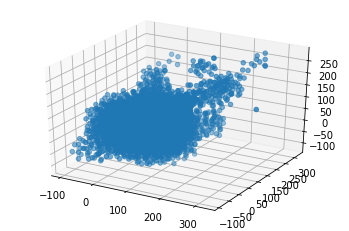

In [16]:
def animate(frame):
    pos, vel = model.forward(torch.FloatTensor([0,0,0]).cuda(),
                             torch.FloatTensor([-300,-300,-300]).cuda(),
                             .5,1,200.)
    ax.clear()
    pos = pos.cpu()
    
    ax.scatter(pos[:,0],pos[:,1],pos[:,2])


torch.manual_seed(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos = model.t_pos.cpu()
    
graph  = ax.scatter(pos[:,0],pos[:,1],pos[:,2])
anim = animation.FuncAnimation(fig, animate,
                               frames=200,
                               interval=50)


In [ ]:
## PyTorch
anim.save('boids_1.mp4')
from IPython.display import HTML
HTML(anim.to_jshtml())